# Trabajo Final
## Martina Acevedo

Los datos que utilizo en este trabajo provienen de simulaciones realizadas en mi trabajo de maestría. Para entender de qué se trata, deben leer primero el archivo `NoLearning.ipynb`, donde genero los datos que aquí utilizare.

Resumiendo la implementación mencionada, en la simulación tengo un arreglo de 200 neuronas 'biológicas', las cuales son los nodos de una red. Estos nodos están conectados con cierta probabilidad, y la fuerza de conexión sigue una distribución gaussiana.

Cada neurona tiene una variable interna (potencial de membrana) y una variable de salida (corriente hacia otras neuronas) asociadas. Estas variables evolucionan según ecuaciones diferenciales que dependen de las salidas y de la fuerza de conexión con las demás neuronas. En otras palabras, la salida de una neurona dependerá de la salida de las demás neuronas. El sistema utilizado es de la forma:

![alt text](RNN.png)

Donde los dos colores indican que las neuronas tienen dos dinámicas distintas (salidas distintas ante un mismo input)

Podemos considerar que la salida de todas las `N` neuronas a tiempo `t` se puede representar con un punto en un espacio `N` dimensional, donde cada eje representa la salida de una neurona. Entonces, si consideramos la evolución en el tiempo de las neuronas, obtendremos muchos puntos en dicho espacio.

Ahora, si la dinámica de una neurona se ve influenciada por las demás, ¿Será posible que esos puntos se puedan representar en un espacio de menor dimensionalidad? ¿Cómo sería dicho espacio?

Visualicemos un caso hipotético en el que tenemos 3 neuronas interconectadas. Sus salidas en función del tiempo están dadas por la figura de abajo (izquierda). A la derecha muestro la gráfica de dichas variables en el espacio cuyos ejes están definidos por las salidas de cada neurona. Observamos que la dimensionalidad de los datos de las salidas de las neuronas es menor que la dimensionalidad del espacio (3D), ya que estos se encuentran contenidos en un plano (2D). De esta manera, en este caso, podríamos representar los datos en un espacio de dimensionalidad menor.


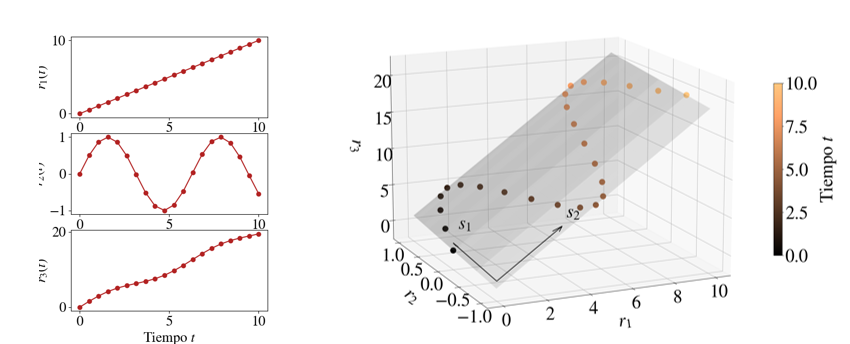

Para analizar la dimensionalidad de los datos obtenidos en la simulación utilizare las siguientes técnicas:
- PCA
- Isomap
- Autoencoders

Sobre las cuales hablaré a lo largo del trabajo

### Comencemos haciendo un EDA.

Importemos las librerías necesarias.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importamos los datos desde archivos csv.

In [58]:
df1 = pd.read_csv('prueba2.csv')
data_array = df1.values

Como vimos previamente, mis datos constan de las salidas (promediadas en ventanas temporales) de todas las neuronas de la red a diferentes instantes de tiempo.

Tenemos:
- 200 neuronas (columnas).
- 2000 iteraciones de tiempo (filas).

In [59]:
print(df1.head())

        i=1       i=2       i=3       i=4       i=5       i=6       i=7  \
0  3.880250  0.000000  2.404105  1.126908  2.470398  7.409896  2.084980   
1  5.912295  0.809663  3.429886  0.916503  8.582066  3.410119  0.017583   
2  0.156166  4.679825  2.782477  3.671883  4.356240  2.819491  3.221085   
3  4.746649  5.778982  3.292554  0.028294  0.027191  8.918803  5.952573   
4  1.714793  0.611394  3.524881  6.845976  6.230984  0.313472  0.005830   

        i=8       i=9      i=10  ...     i=191     i=192     i=193     i=194  \
0  3.495341  0.582399  1.298013  ...  4.491793  0.000000  3.165119  1.584389   
1  6.121597  8.377031  4.290148  ...  2.636155  6.435853  0.270767  6.800079   
2  9.893768  0.220019  7.930132  ...  0.000258  4.362740  0.181202  4.383497   
3  7.537136  1.564749  6.187720  ...  2.619349  4.773418  9.007168  0.001266   
4  3.502900  7.010855  8.630530  ...  7.306892  4.304942  1.040448  3.187399   

      i=195     i=196     i=197     i=198     i=199     i=200  
0  1

In [60]:
# Ver estadísticas descriptivas
print(df1.describe())

                i=1          i=2           i=3           i=4           i=5  \
count  2.000000e+03  2000.000000  2.000000e+03  2.000000e+03  2.000000e+03   
mean   4.386355e+00     4.453324  4.234821e+00  4.047698e+00  3.717351e+00   
std    3.258278e+00     2.961935  2.994427e+00  2.779024e+00  3.129354e+00   
min    1.517087e-15     0.000000  1.985725e-13  2.725905e-10  3.227364e-22   
25%    1.524990e+00     1.961690  1.713805e+00  1.729103e+00  7.905903e-01   
50%    4.076183e+00     4.278989  3.990618e+00  3.907110e+00  3.129249e+00   
75%    6.934090e+00     6.726028  6.398588e+00  6.161185e+00  6.135050e+00   
max    1.025641e+01    10.256410  1.025641e+01  1.025638e+01  1.025641e+01   

                i=6           i=7           i=8           i=9          i=10  \
count  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03  2.000000e+03   
mean   4.134105e+00  3.892435e+00  4.909559e+00  3.606386e+00  4.203473e+00   
std    3.448103e+00  3.336721e+00  2.787570e+00  2.836693e+0

Veamos cómo luce la salida de una neurona en función del tiempo

Como cada neurona puede seguir uno de dos distintos tipos de dinámicas (QIF O LIF), graficamos una neurona de cada tipo.

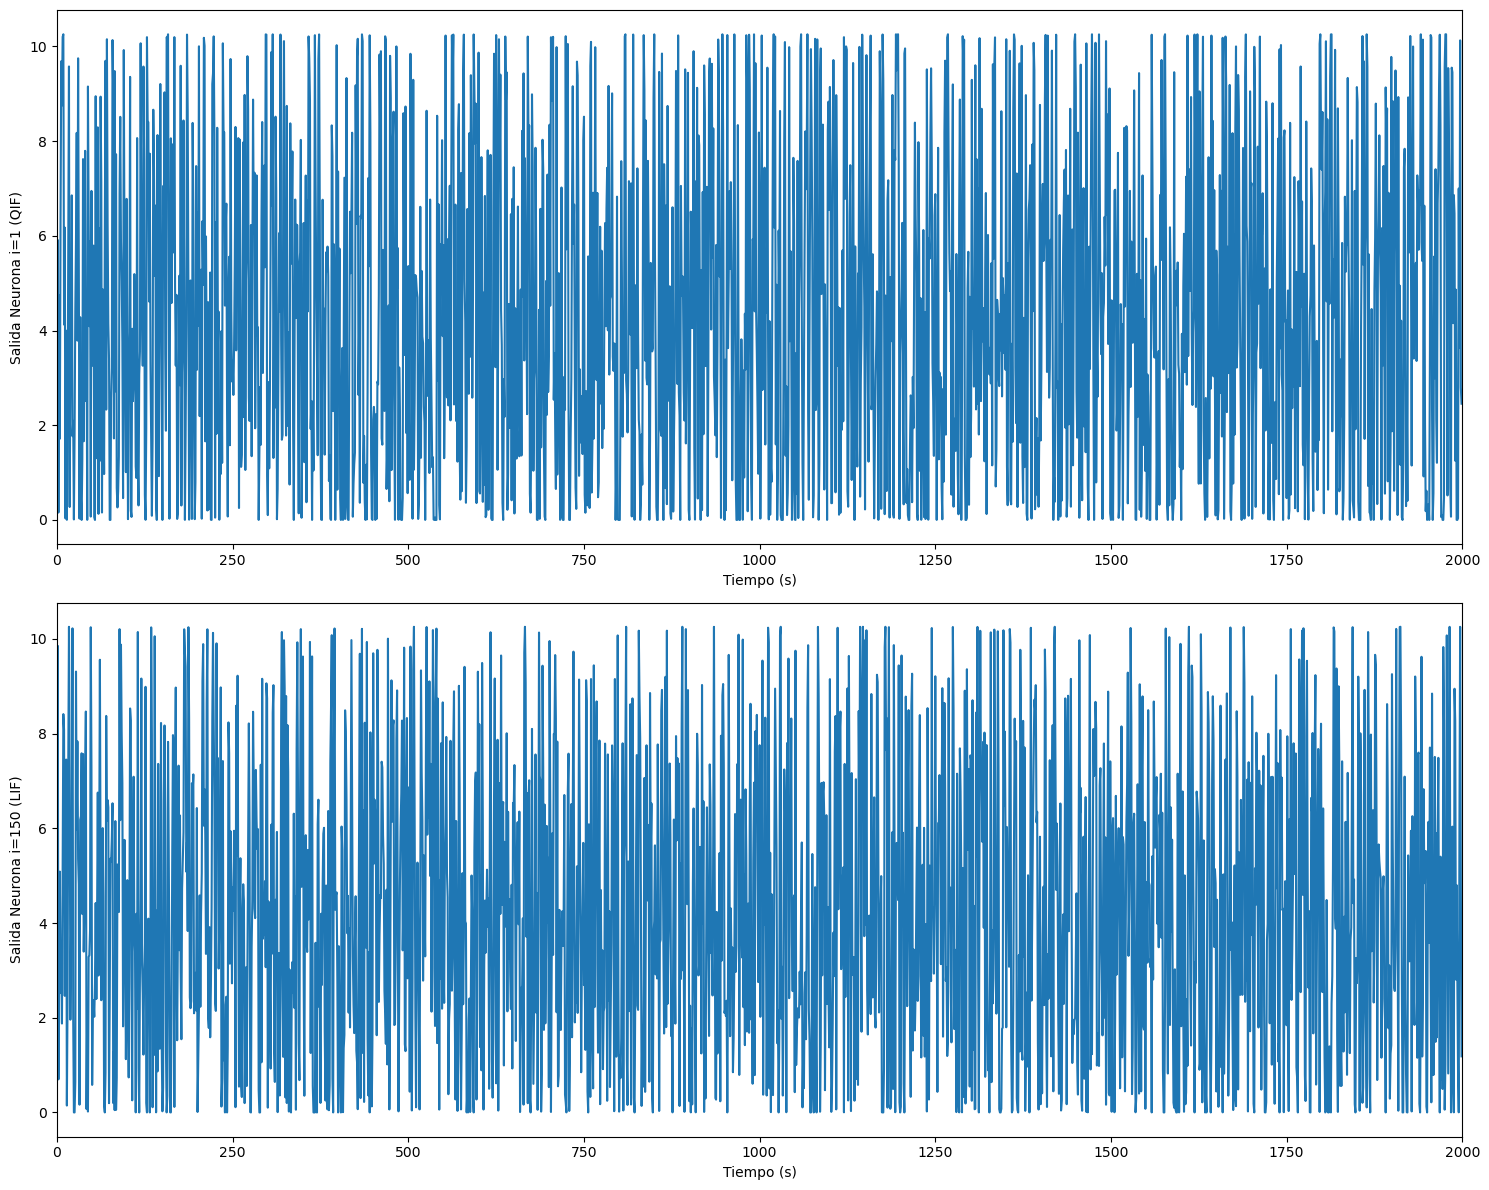

In [55]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

ax1.plot(df1.index, df1['i=1'])
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Salida Neurona i=1 (QIF)')
ax1.set_xlim(0, 2000)

ax2.plot(df1.index, df1['i=150'])
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Salida Neurona i=150 (LIF)')
ax2.set_xlim(0, 2000)

# Mostrar la figura
plt.tight_layout()
plt.show()


Vemos que los valores que pueden tomar las salidas (`rprom` en el código), se ven limitadas. Estos límites provienen de la condición de emisión de disparos de cada uno de los modelos. Miremos un poco más de cerca cómo evolucionan las salidas.

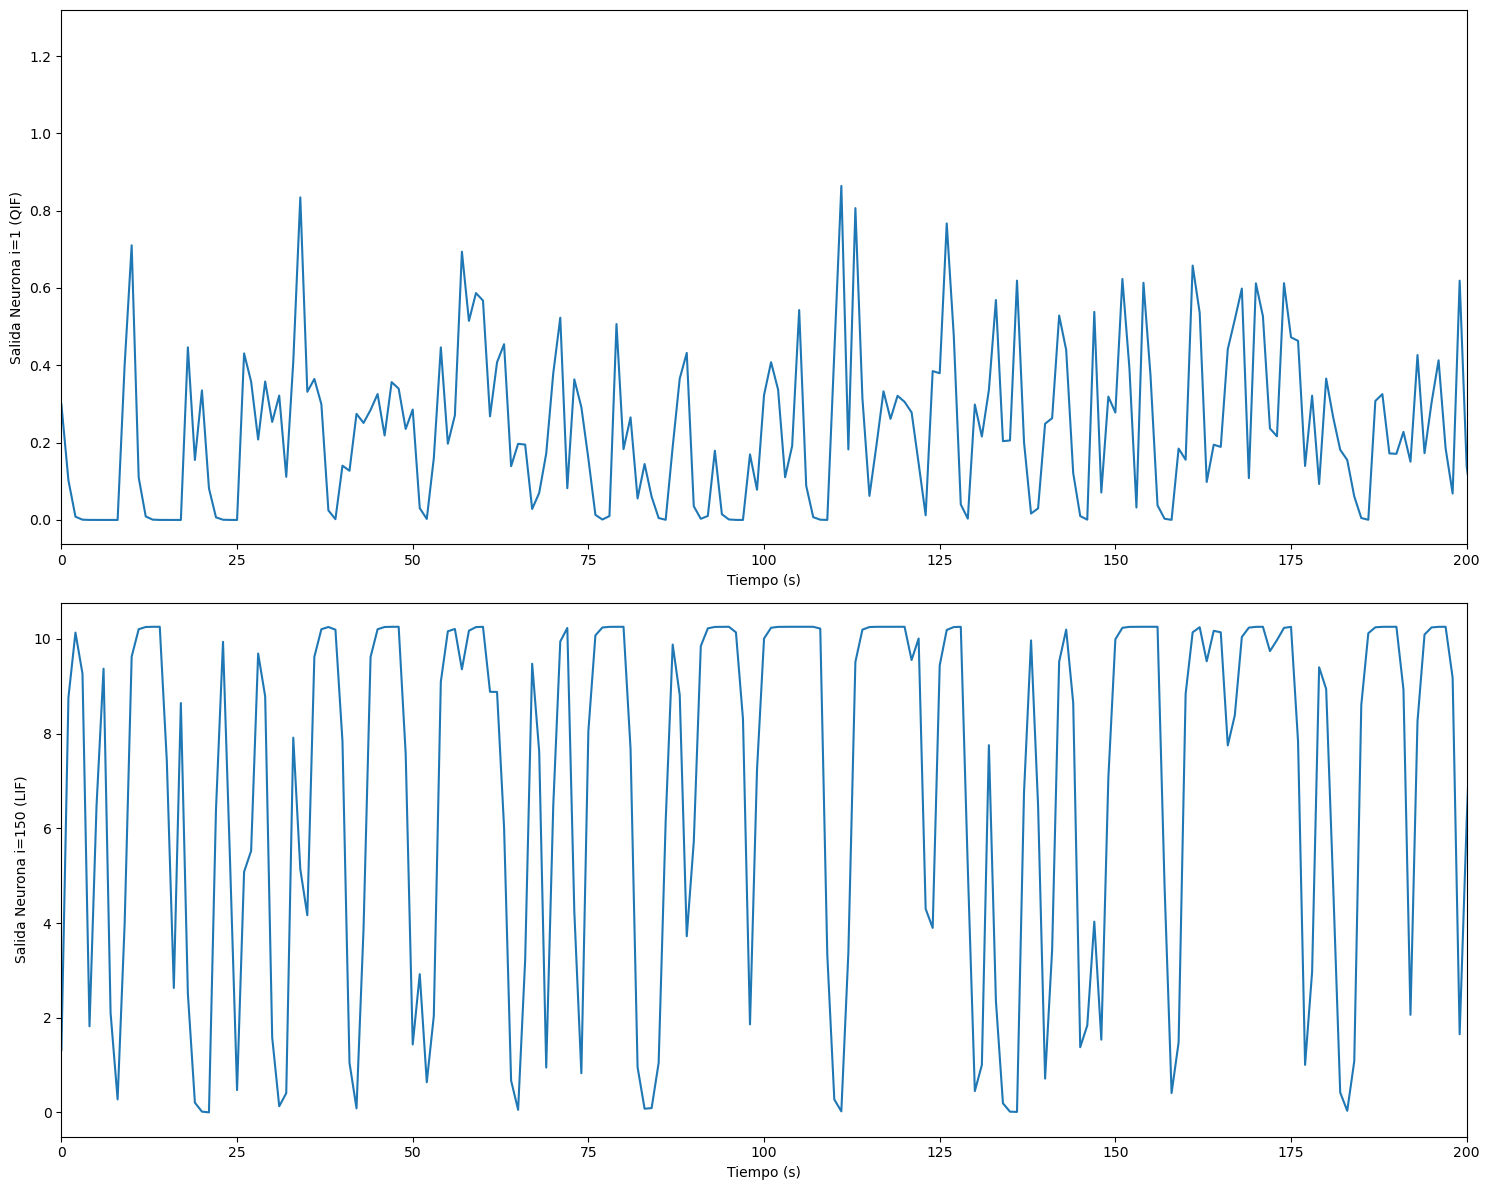

In [40]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

ax1.plot(df1.index, df1['i=1'])
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Salida Neurona i=1 (QIF)')
ax1.set_xlim(0, 200)

ax2.plot(df1.index, df1['i=150'])
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Salida Neurona i=150 (LIF)')
ax2.set_xlim(0, 200)

# Mostrar la figura
plt.tight_layout()
plt.show()

Veamos cómo resultan las distribuciones de las salidas de estas neuronas

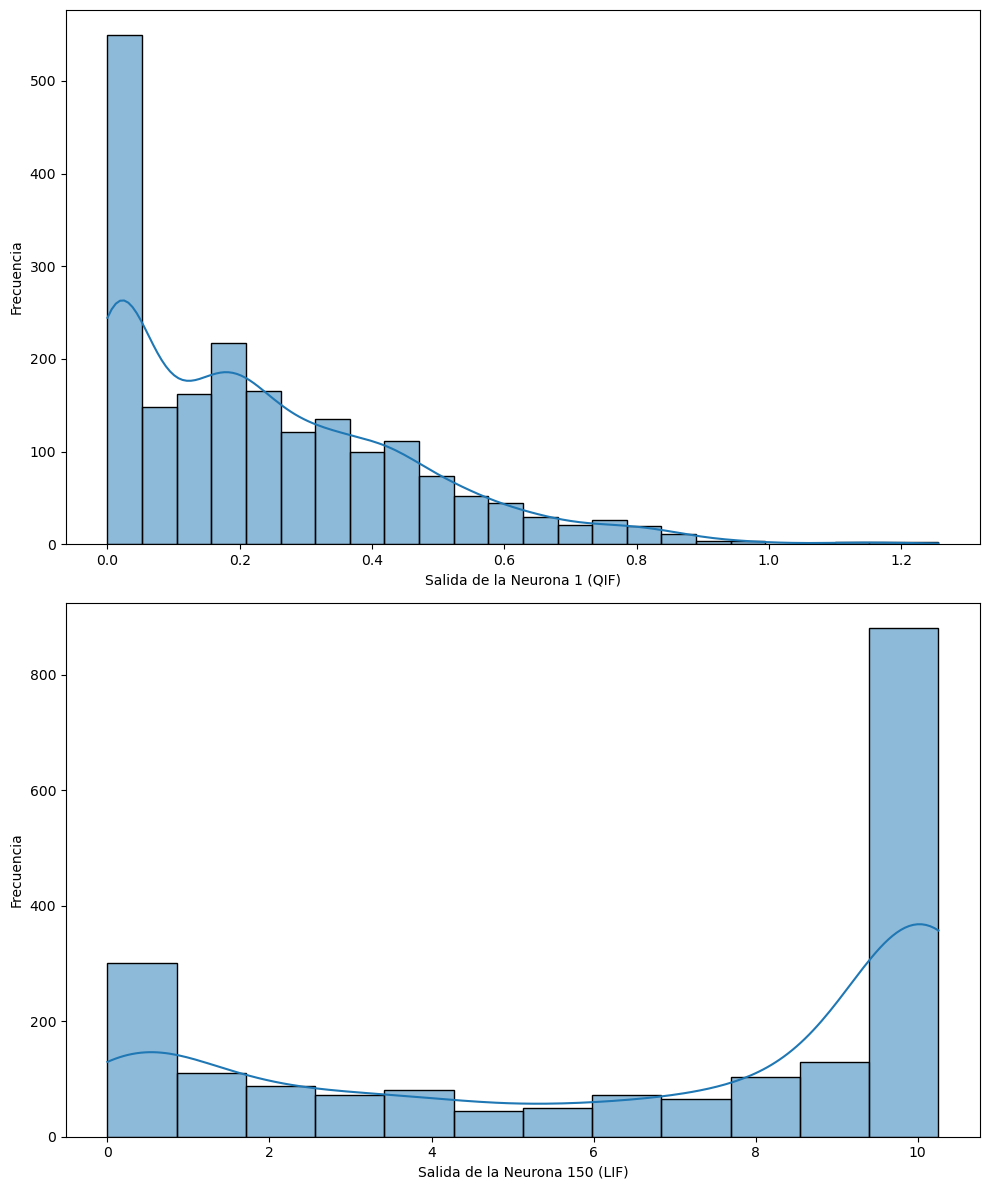

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

sns.histplot(df1['i=1'], kde=True, ax=ax1)
ax1.set_xlabel('Salida de la Neurona 1 (QIF)')
ax1.set_ylabel('Frecuencia')

sns.histplot(df1['i=150'], kde=True, ax=ax2)
ax2.set_xlabel('Salida de la Neurona 150 (LIF)')
ax2.set_ylabel('Frecuencia')

plt.tight_layout()

plt.show()


Notamos que las distribuciones para cada tipo de neurona son muy distintas (graficando más datos, se puede observar que las distribuciones para neuronas de igual tipo son similares)

La salida de las neuronas varía en el tiempo. Entonces una pregunta válida es ¿Depende el potencial actual de la neurona de lo que ocurrió en tiempos anteriores?

Para contestar esta pregunta, grafiquemos la autocorrelación en función de diferentes retardos para nuestras neuronas ejemplo.

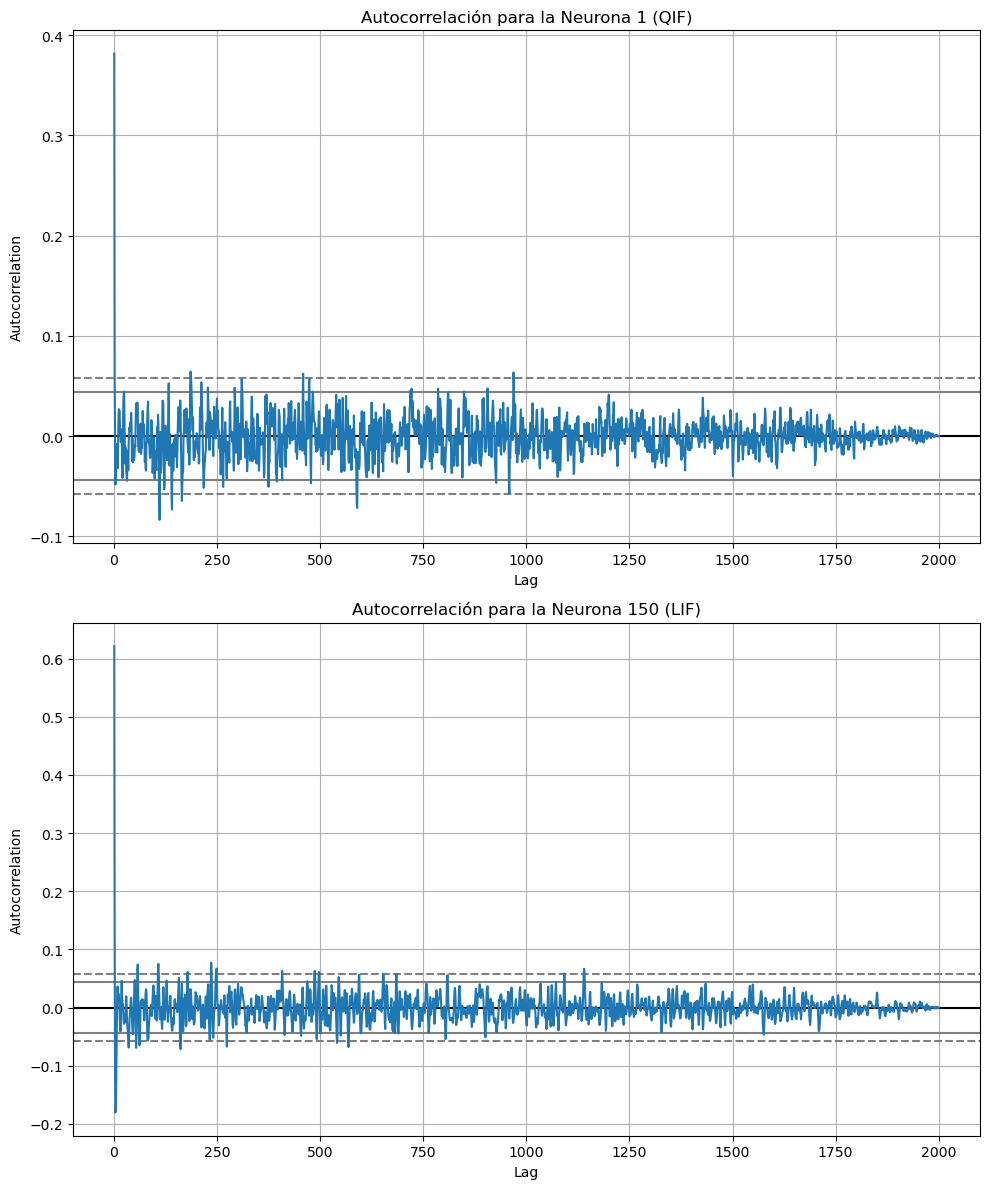

In [42]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

autocorrelation_plot(df1['i=1'], ax=ax1)
ax1.set_title('Autocorrelación para la Neurona 1 (QIF)')

autocorrelation_plot(df1['i=150'], ax=ax2)
ax2.set_title('Autocorrelación para la Neurona 150 (LIF)')

plt.tight_layout()

plt.show()


Observamos que las salidas de las neuronas se ven más influenciadas por lo que pasó en tiempos recientes, pues la autocorrelación disminuye en módulo al aumentar `Lag`. Veamos que ocurre para lags pequeños.


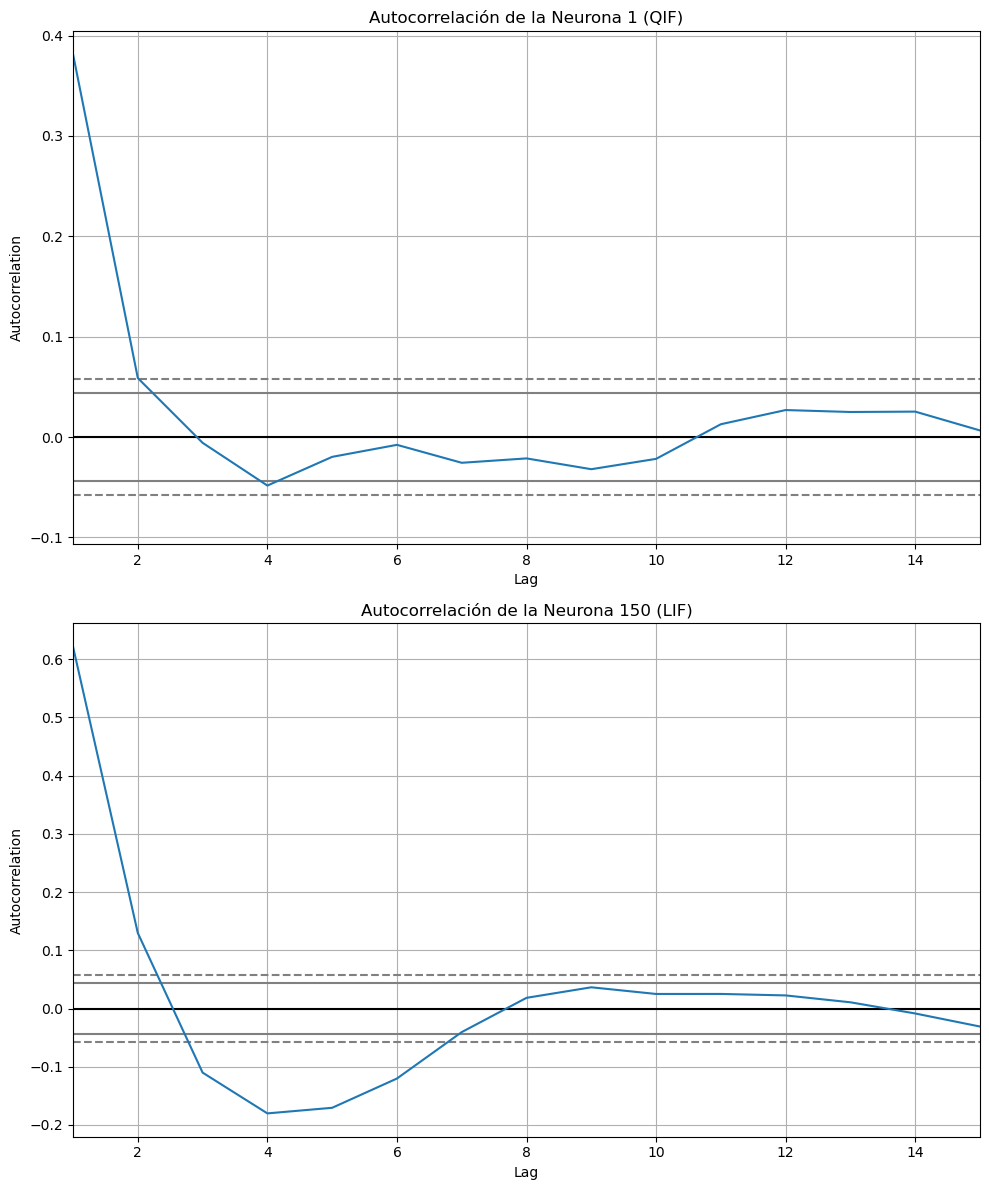

In [43]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# Crear la figura y los ejes para los subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Primer subplot: Autocorrelación para la neurona i=1
autocorrelation_plot(df1['i=1'], ax=ax1)
ax1.set_title('Autocorrelación de la Neurona 1 (QIF)')
ax1.set_xlim(1, 15)

# Segundo subplot: Autocorrelación para la neurona i=150
autocorrelation_plot(df1['i=150'], ax=ax2)
ax2.set_title('Autocorrelación de la Neurona 150 (LIF)')
ax2.set_xlim(1, 15)

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura completa
plt.show()


Tenemos autocorrelación alta con un lag 1 iteración.

Vimos lo que ocurre con una  neuronas individuales, veamos que sucede con las neuronas en conjunto. Para ello analicemos el potencial promedio y la desviación estándar en función del tiempo.

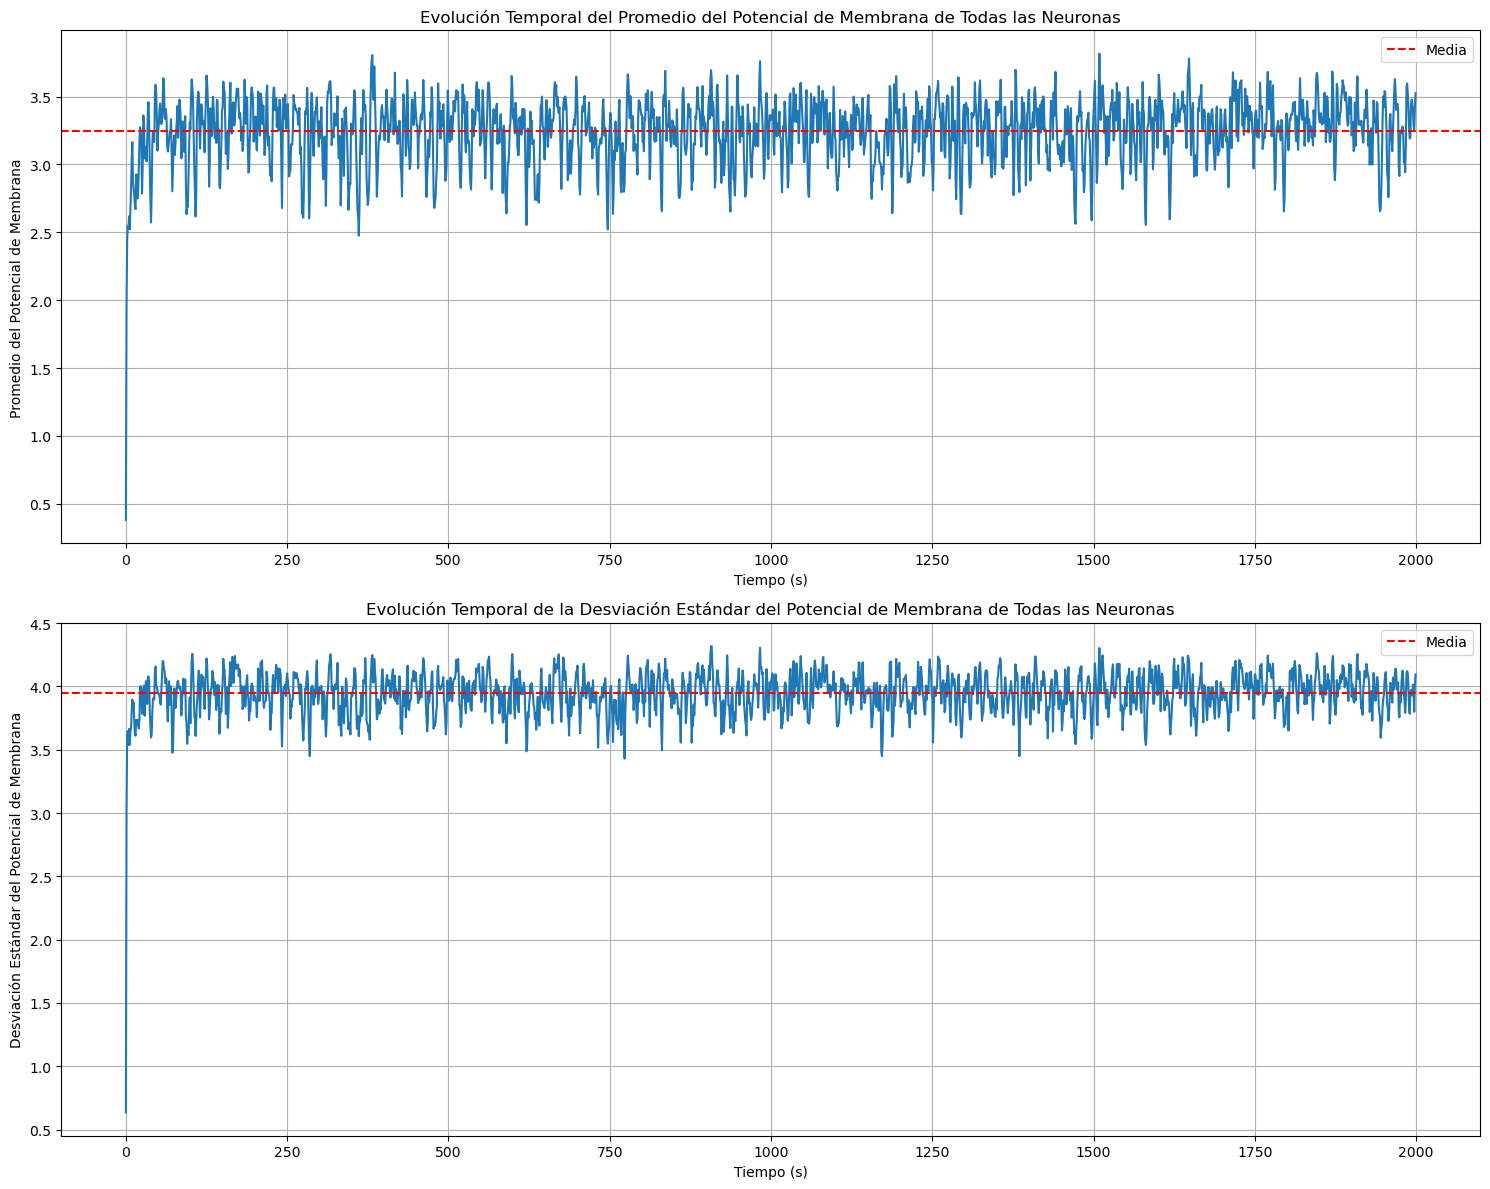

In [44]:
import matplotlib.pyplot as plt

# Calcular las series de tiempo
mean_potential = df1.mean(axis=1)
std_potential = df1.std(axis=1)

# Crear los subplots verticales
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

# Graficar el promedio del potencial de membrana
axs[0].plot(df1.index, mean_potential)
axs[0].axhline(y=mean_potential.mean(), color='r', linestyle='--', label='Media')
axs[0].set_title('Evolución Temporal del Promedio del Potencial de Membrana de Todas las Neuronas')
axs[0].set_xlabel('Tiempo (s)')
axs[0].set_ylabel('Promedio del Potencial de Membrana')
axs[0].legend()
axs[0].grid()

# Graficar la desviación estándar del potencial de membrana
axs[1].plot(df1.index, std_potential)
axs[1].axhline(y=std_potential.mean(), color='r', linestyle='--', label='Media')
axs[1].set_title('Evolución Temporal de la Desviación Estándar del Potencial de Membrana de Todas las Neuronas')
axs[1].set_xlabel('Tiempo (s)')
axs[1].set_ylabel('Desviación Estándar del Potencial de Membrana')
axs[1].legend()
axs[1].grid()

# Mostrar los gráficos
plt.tight_layout()
plt.show()



Notamos que tanto la media como la distribución estándar del potencial medio de las neuronas oscilan en torno a un valor (línea roja punteada). Esto podría indicar que, las neuronas mantienen un cierta salida promedio durante el período de tiempo analizado.

Debido a las conexiones presentes entre neuronas estas no operan de manera aislada, es por ello que queremos analizar la correlación entre sus actividades. 

Comencemos mirando la matriz de correlación.

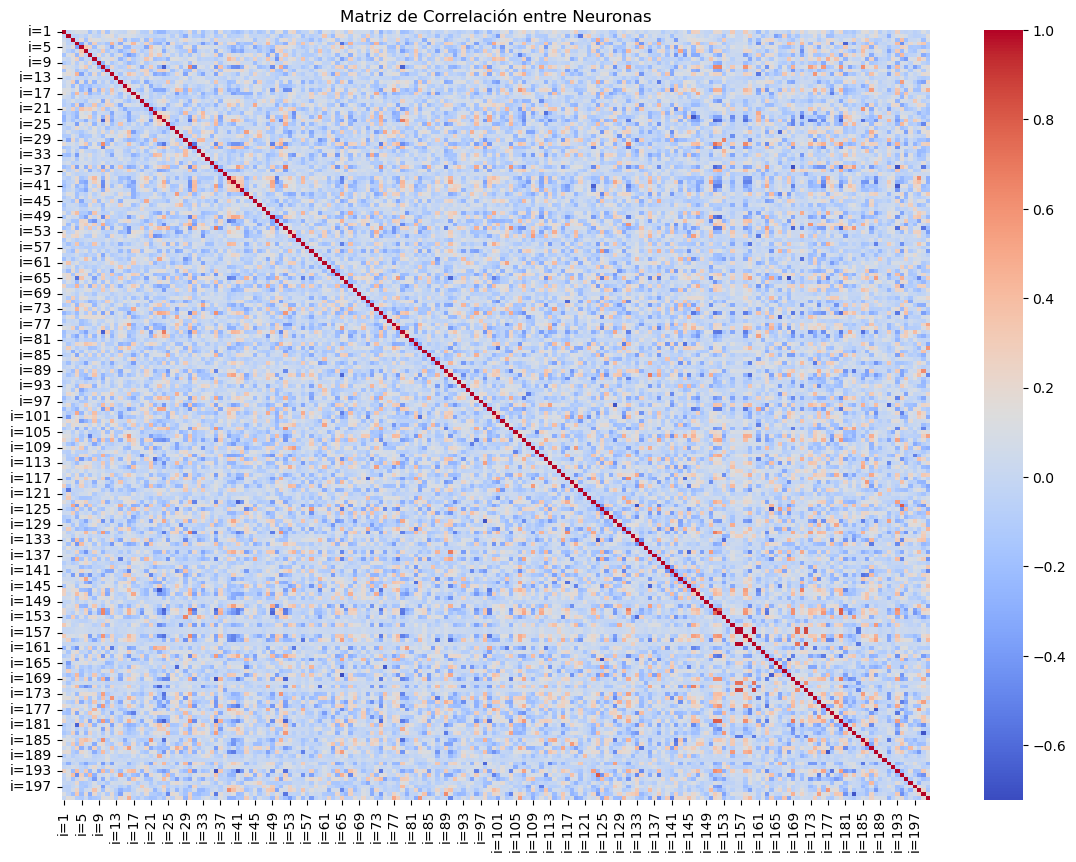

In [45]:
plt.figure(figsize=(14, 10))
correlation_matrix = df1.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Matriz de Correlación entre Neuronas')
plt.show()


Si bien hay puntos con mayor correlación (en módulo), no notamos un patrón marcado. 

Por ello, utilizo un método de clusterización para reordenar la matriz de covarianza y agrupar neuronas con perfiles más similares. En el dendrograma (árbol)que utiliza este método, las ramas que se unen a diferentes alturas representan agrupamientos de neuronas más similares entre sí en términos de sus salidas. Las ramas que se unen a una altura menor indican agrupamientos más similares, mientras que las ramas que se unen a una altura mayor indican agrupamientos menos similares. Esto nos permite identificar clústeres de neuronas con perfiles de actividad similares.

Para armar las ramas se utiliza el método `ward`, el cual intenta minimizar la varianza dentro de cada grupo, lo que significa que tiende a formar clústeres compactos. 

c:\Users\Martina\miniconda3\envs\TPF\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Martina\miniconda3\envs\TPF\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


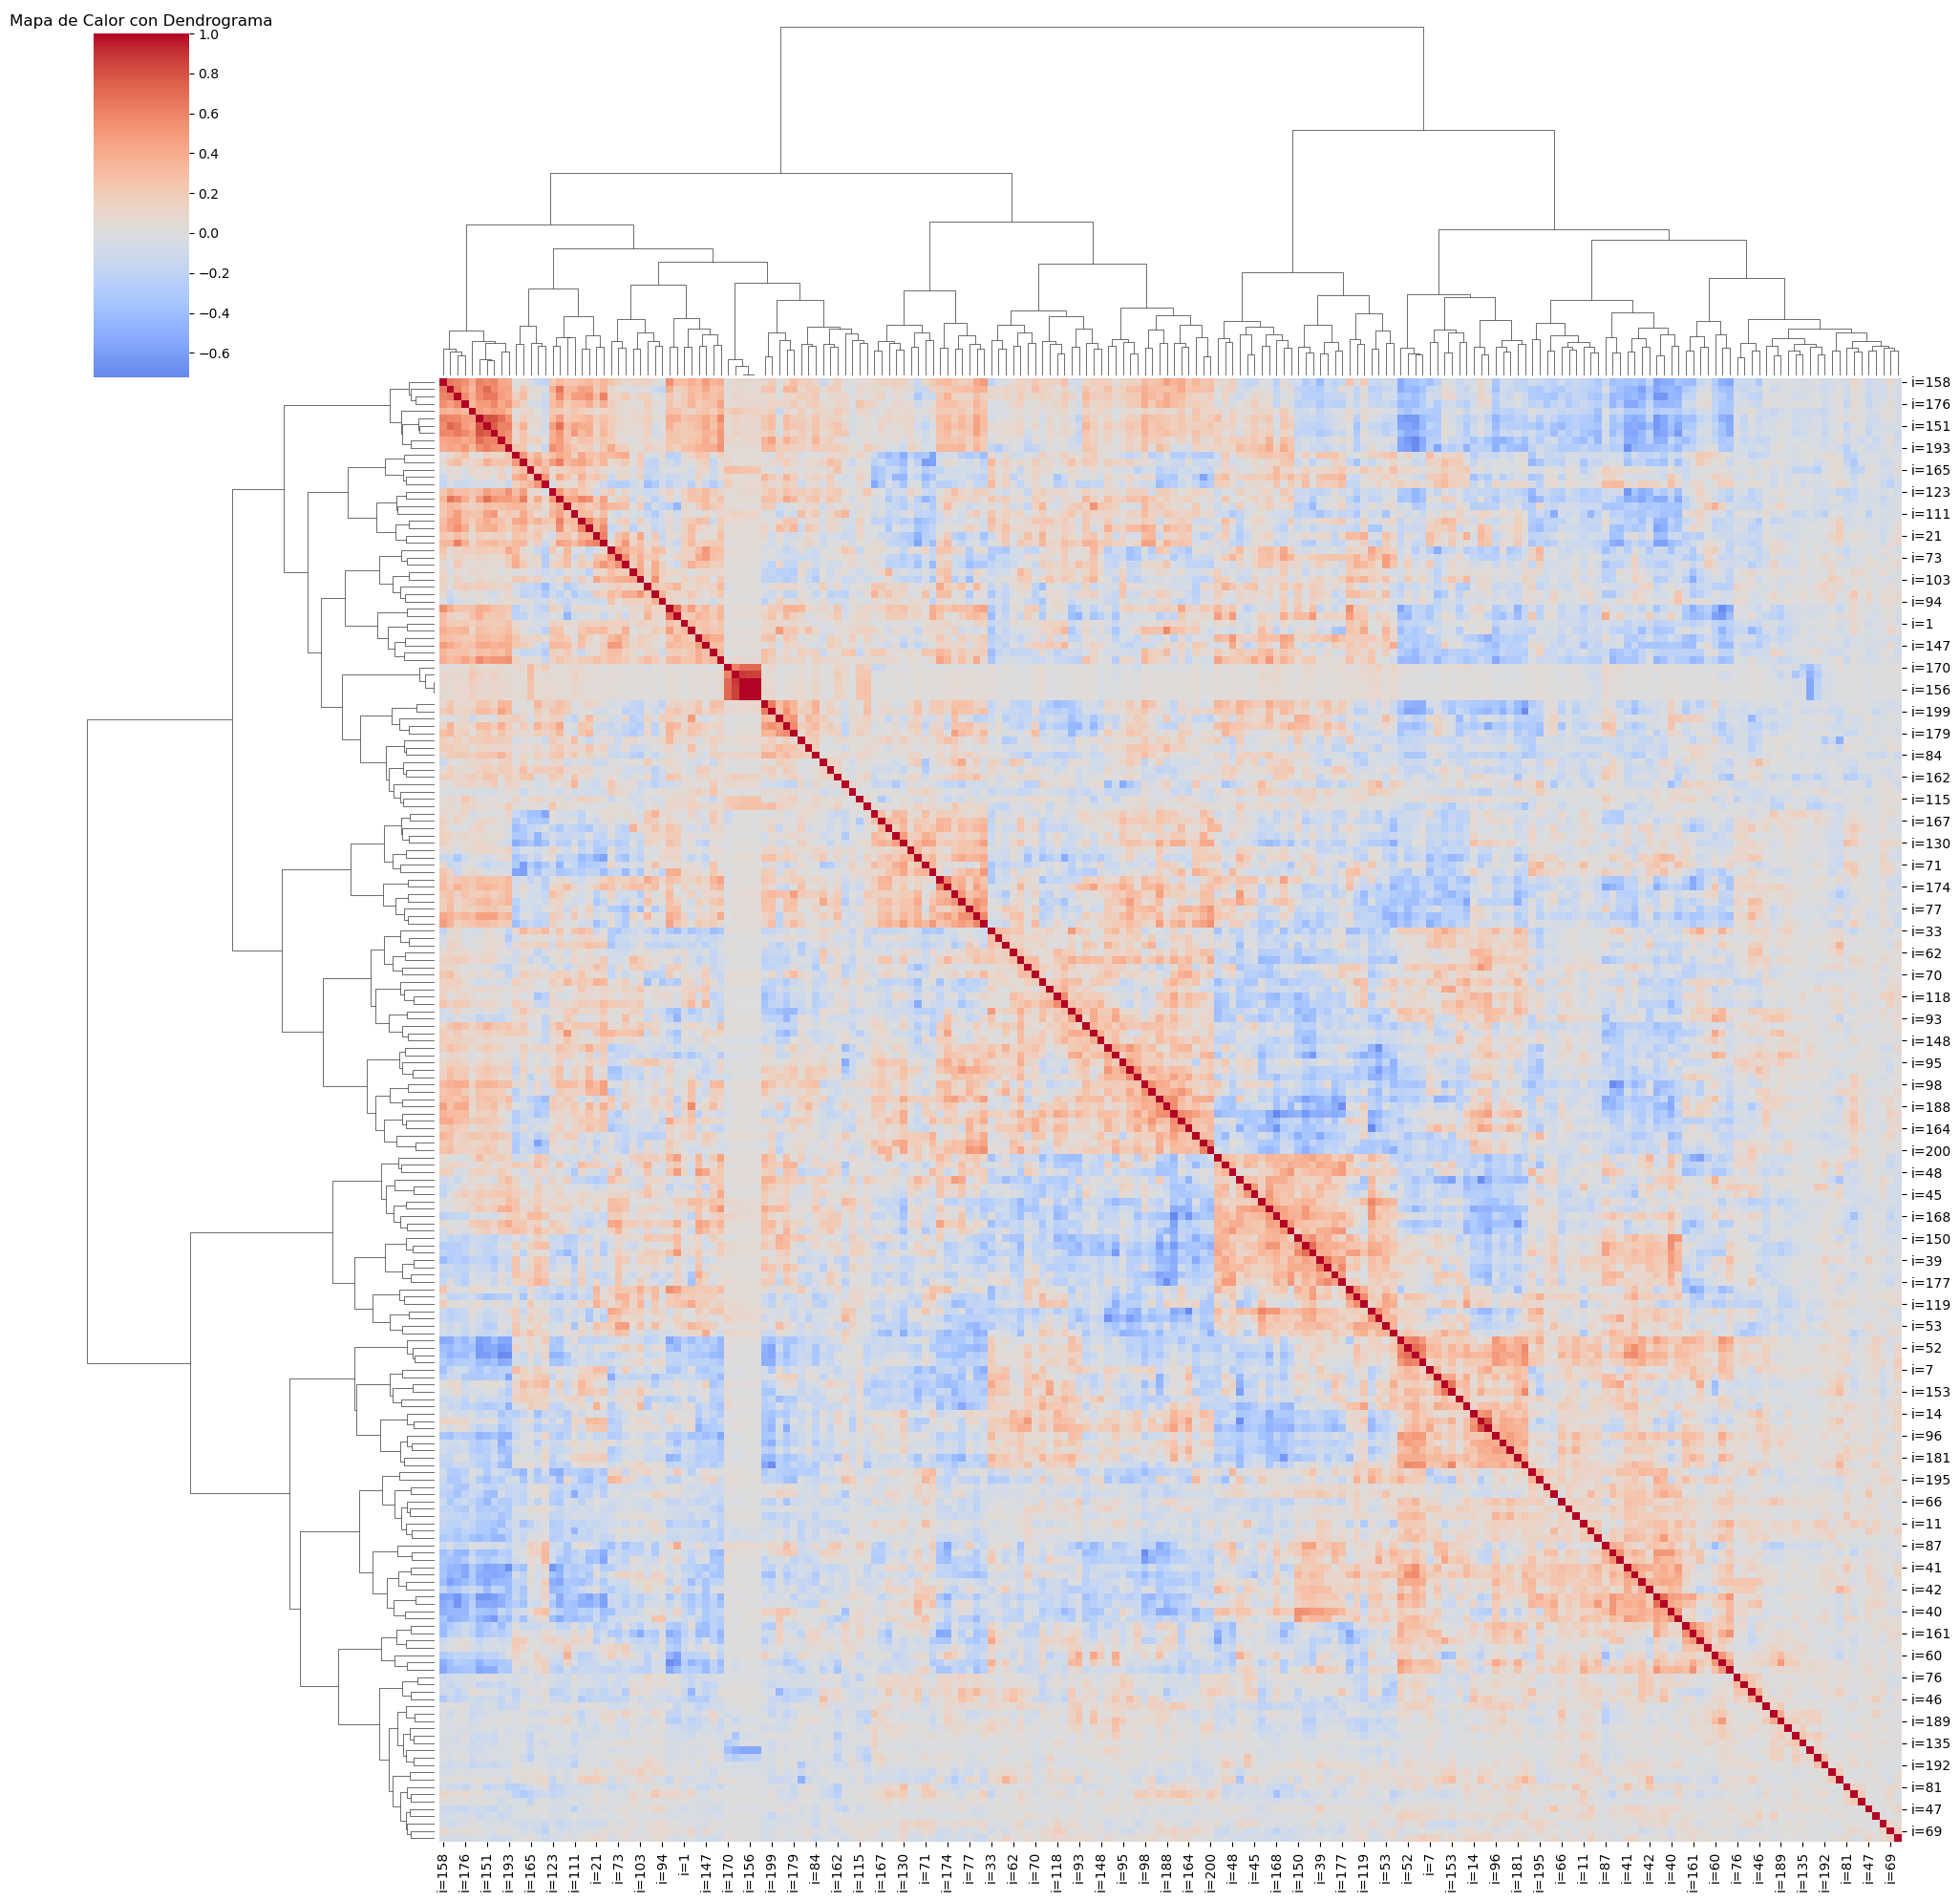

In [46]:
sns.clustermap(correlation_matrix, cmap='coolwarm', center=0, figsize=(20, 20), method='ward')
plt.title('Mapa de Calor con Dendrograma')
plt.show()


De acá vemos mejor que hay correlaciones presentes entre pares de neuronas.

Comenzemos haciendo PCA, para analizar la dimensionalidad del sistema

In [47]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data_array)

PCA()

### ¿Cómo podemos determinar la dimensionalidad efectiva?
1. Calculamos la matriz de covarianza
2. Calculamos sus autovalores $ \lambda $
3. Calculamos la dimensión efectiva partir de la dimensión de participación (Participation Ratio)
$$ Dpr = \frac{ (\sum_i \lambda_i)^2}{\sum \lambda_i^2} $$

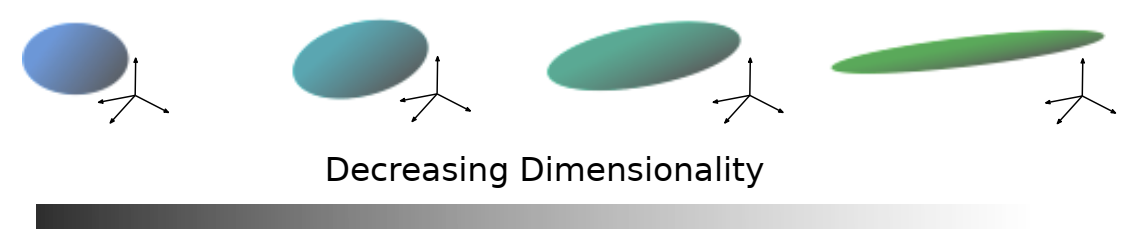

In [48]:
autovalores = pca.explained_variance_
#print('Autovalores:', autovalores)
# Calculo el participation ratio
participation_ratio = (np.sum(autovalores) ** 2) / np.sum(autovalores ** 2)
print('Participation ratio:', participation_ratio)

Participation ratio: 15.631676443995422


Varianza explicada por componente:
$$ V = \frac{\lambda_i}{\sum_{i=1}^{n} \lambda_i} $$

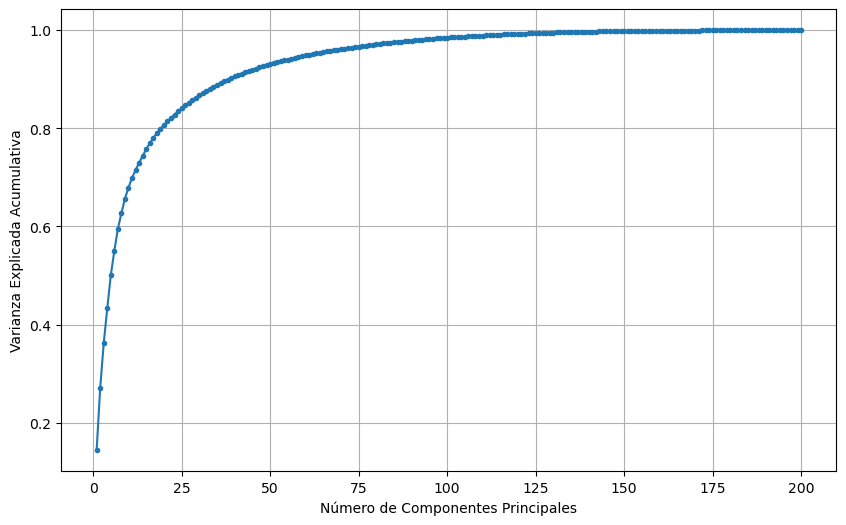

In [49]:
total_dimensiones = len(autovalores)

explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, total_dimensiones + 1), explained_variance_ratio_cumulative, marker='.')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulativa')
plt.grid(True)
plt.show()


In [50]:
threshold = 0.80
num_components = np.argmax(explained_variance_ratio_cumulative >= threshold) + 1
print(f"La cantidad de componentes principales que contiene el 80% de la varianza es {num_components}")


La cantidad de componentes principales que contiene el 80% de la varianza es 20


Tenemos que PCA es una técnica de reducción de dimensionalidad lineal, es decir que busca proyectar los datos en un espacio de menor dimensión mediante una combinación lineal de las características originales.
Para incluir la posibilidad de que nuestro espacio no sea lineal, podemos aplicar a nuestra data métodos de reducción de dimensionalidad no lineales. Comencemos con Isomap


Isomap (Isometric Mapping) es una técnica de reducción de dimensionalidad no lineal que intenta preservar las distancias geodésicas (las distancias más cortas a lo largo de la estructura no lineal de los datos). Construye un grafo de vecinos más cercanos y calcula las distancias geodésicas entre los puntos, proyectando luego los datos en un espacio de menor dimensión.


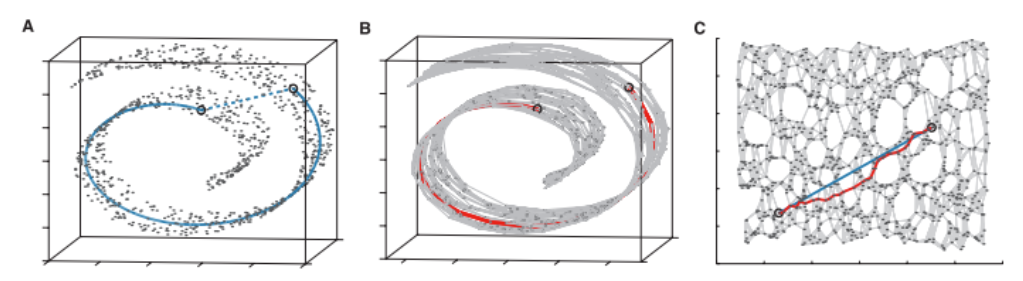

En el paper original de Isomap, se muestra una forma de contabilizar que tan bien preservan las distancias con los métodos de PCA e Isomap.
Esto se hace por medio del coeficiente `residual variance`.

El cálculo de la varianza residual se define como:

$$\text{Varianza residual} = 1 - \rho^2_{DXDY}$$

donde $\rho_{DXDY}$ es el coeficiente de correlación lineal estándar, calculado sobre todas las entradas de $DX$ y $DY$ con

- $DX$: matriz de distancias geodésicas (Isomap) o euclídeas (PCA) en el espacio de datos de alta dimensión.
- $DY$: matriz de distancias euclídeas en el espacio embebido.

Una varianza residual baja indica que la técnica mantiene bien las distancias originales.

Calculando para 2 componentes...
(2000, 2000)
Calculando para 3 componentes...
(2000, 2000)
Calculando para 4 componentes...
(2000, 2000)
Calculando para 5 componentes...
(2000, 2000)
Calculando para 6 componentes...
(2000, 2000)
Calculando para 7 componentes...
(2000, 2000)
Calculando para 8 componentes...
(2000, 2000)
Calculando para 9 componentes...
(2000, 2000)
Calculando para 10 componentes...
(2000, 2000)
Calculando para 11 componentes...
(2000, 2000)
Calculando para 12 componentes...
(2000, 2000)
Calculando para 13 componentes...
(2000, 2000)
Calculando para 14 componentes...
(2000, 2000)
Calculando para 15 componentes...
(2000, 2000)
Calculando para 16 componentes...
(2000, 2000)
Calculando para 17 componentes...
(2000, 2000)
Calculando para 18 componentes...
(2000, 2000)
Calculando para 19 componentes...
(2000, 2000)
Calculando para 20 componentes...
(2000, 2000)
Calculando para 21 componentes...
(2000, 2000)
Calculando para 22 componentes...
(2000, 2000)


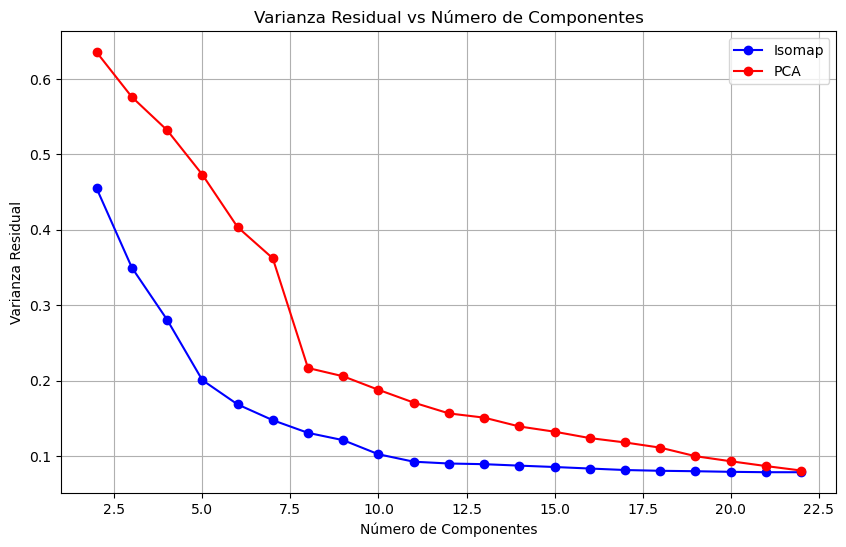

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.metrics import euclidean_distances
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Rango de componentes para evaluar
componentes = range(2, 23)

# Almacenar resultados de varianza residual
residual_variances_isomap = []
residual_variances_pca = []

# Función para calcular la varianza residual
def calculate_residual_variance(DX, DY):
    correlation_matrix = np.corrcoef(DX.ravel(), DY.ravel())
    rho_DXDY = correlation_matrix[0, 1]
    residual_variance = 1 - rho_DXDY**2
    return residual_variance

scaler = StandardScaler()
df1_ = scaler.fit_transform(df1)
# Matriz de distancias euclídeas en el espacio original
DX = euclidean_distances(df1_)

# Iterar sobre diferentes números de componentes
for n_components in componentes:
    print(f'Calculando para {n_components} componentes...')
    # Aplicar Isomap para reducción de dimensionalidad
    n_neighbors = 30
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    data_transformed_isomap = isomap.fit_transform(df1_)
    
    # DG es la matriz de distancias geodésicas en el espacio de alta dimensión
    DG = isomap.dist_matrix_
    print(DG.shape)
    
    # DY es la matriz de distancias euclídeas en el espacio embebido de Isomap
    DY_isomap = euclidean_distances(data_transformed_isomap)
    
    # Calcular la varianza residual en Isomap
    residual_variance_isomap = calculate_residual_variance(DG, DY_isomap)
    residual_variances_isomap.append(residual_variance_isomap)
    
    # Aplicar PCA para reducción de dimensionalidad
    pca = PCA(n_components=n_components)
    data_transformed_pca = pca.fit_transform(df1_)
    
    # DY es la matriz de distancias euclídeas en el espacio embebido de PCA
    DY_pca = euclidean_distances(data_transformed_pca)
    
    # Calcular la varianza residual en PCA
    residual_variance_pca = calculate_residual_variance(DX, DY_pca)
    residual_variances_pca.append(residual_variance_pca)

# Graficar varianza residual vs número de componentes para Isomap y PCA
plt.figure(figsize=(10, 6))
plt.plot(componentes, residual_variances_isomap, marker='o', linestyle='-', color='b', label='Isomap')
plt.plot(componentes, residual_variances_pca, marker='o', linestyle='-', color='r', label='PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Residual')
plt.title('Varianza Residual vs Número de Componentes')
plt.legend()
plt.grid(True)
plt.show()


Notamos que tomando una cantidad de componentes pequeña, Isomap preserva mejor las distancias que PCA.

Antes medimos la dimensionalidad efectiva con PCA, utilizando los autovalores de la matriz de covarianza. ¿Se podrá medir un coeficiente análogo a partir de Isomap?

Veamos los detalles de ambos algoritmos para ver si podemos hacer alguna equivalencia.

### ¿Cómo funciona PCA?

1. Calculamos la matriz de covarianza $ \mathbf{C} $ de los datos: $$ \mathbf{C} = \frac{1}{n-1} \sum_{i=1}^{n} (\mathbf{x}_i - \mathbf{\mu})(\mathbf{x}_i - \mathbf{\mu})^T $$
   donde $ \mathbf{x}_i $ es el i-ésimo dato y $ \mathbf{\mu} $ es el vector de medias de los datos.

2. Calculamos los autovalores $ \lambda_i $ y autovectores $\mathbf{v}_i$ de la matriz de covarianza $\mathbf{C}$.

3. Para reducir la dimensionalidad a d dimensiones, conservamos los primeros d autovalores más grandes y sus correspondientes autovectores. Proyectamos los datos originales en el nuevo espacio de menor dimensionalidad: $$ \mathbf{Y} = \mathbf{X} \mathbf{W}_d $$
   donde $ \mathbf{W}_d $ es una matriz cuyos columnas son los d autovectores seleccionados.


### ¿Cómo funciona Isomap?

1. Construimos el grafo de vecinos más cercanos. Para cada dato, calculamos las distancias euclidianas a todos los demás datos y conectamos con líneas a los K vecinos más cercanos, formando un grafo.

2. Calculamos las distancias geodésicas $ \delta_{ij} $ entre todos los pares de puntos i y j en el grafo de vecinos más cercanos. Estas distancias geodésicas representan las distancias más cortas a través de los vecinos más cercanos en el espacio de alta dimensión.

3. Construimos la matriz $ \mathbf{D}^2 $ donde cada entrada $ d_{ij}^2 = \delta_{ij}^2 $.

4.  Centramos la matriz $ \mathbf{D}^2 $ para obtener la matriz de Gram. El centrado se realiza usando la fórmula:
    $$
    \mathbf{G} = -\frac{1}{2} \mathbf{H} \mathbf{D}^2 \mathbf{H}
    $$
    donde $ \mathbf{H} = \mathbf{I} - \frac{1}{n} \mathbf{1}\mathbf{1}^T $ es la matriz de centrado, $ \mathbf{I} $ es la matriz identidad, y $ \mathbf{1} $ es un vector columna de unos. Al aplicar H a una matriz de datos, se restan las medias de las filas y columnas, de manera que el resultado tiene medias cero.

5. Descomponemos la matriz de Gram $ \mathbf{G} $ en sus autovalores y autovectores:
    $$
    \mathbf{G} \mathbf{v}_i = \lambda_i \mathbf{v}_i
    $$

6. Para reducir la dimensionalidad a d dimensiones, conservamos los d autovalores más grandes y sus correspondientes autovectores. Proyectamos los datos en este nuevo espacio de menor dimensión:
    $$
    \mathbf{Y} = \mathbf{V}_d \mathbf{\Lambda}_d^{1/2}
    $$
    donde $ \mathbf{V}_d $ son los primeros d autovectores y $ \mathbf{\Lambda}_d $ es una matriz diagonal con los primeros d autovalores.

Notamos que en ambos algoritmos, nos quedamos con los d autovalores más grandes de una matriz (de covarianza o de Gram).

Vemos las diferencias sustanciales entre ambas matrices.

### ¿Cuáles son las diferencias de uso de la matriz de covarianza en PCA y de la matriz de Gram en Isomap?

**Tienen distintos tamaños!!!**
- La matriz de covarianza se usa principalmente en PCA para identificar direcciones de máxima varianza en el espacio de características.
- La matriz de Gram en Isomap se usa para capturar las distancias geodésicas en el espacio de datos y proyectarlas en un espacio de menor dimensión.

### Entonces, ¿ Cuál sería el significado de calcular Dpr con los autovalores de cada matriz?
$$ D_{pr} = \frac{(\sum \lambda_i)^2 }{\sum \lambda_i^2} $$

**Autovalores de la matriz de covarianza**
- El Dpr proporciona una estimación de la dimensionalidad efectiva del espacio en el que los datos residen.
- Si algunos autovalores son significativamente mayores que otros, el Dpr será menor que el número total de autovalores, indicando que solo unos pocos componentes principales explican la mayor parte de la varianza en los datos.
- Un valor alto de Dpr indica que los datos se distribuyen de manera relativamente uniforme a través de múltiples dimensiones. Mientras que un valor bajo de Dpr sugiere que los datos están concentrados en un subespacio de menor dimensión.

**Autovalores de la matriz de Gram**
- El Dpr para la matriz de Gram en Isomap proporcionará una estimación de la dimensionalidad efectiva de la manifold subyacente en la que residen los datos.
- En este contexto, un valor alto de Dpr indicará que los datos se distribuyen en un espacio de alta dimensión en términos de sus distancias geodésicas.
- Si la manifold es intrínsecamente de baja dimensión, los autovalores correspondientes a las direcciones principales serán significativamente mayores, y el PR reflejará la dimensionalidad intrínseca menor. Ahora, la manifold tiene una estructura compleja de alta dimensión, esto se reflejará en un Dpr más alto.

### Comparación
Veamos dos ejemplos conceptuales en los cuales el Dpr calculado a parir de las distintas matrices daría resultados cualitativamente distintos.

**Ejemplo 1: Elipsoide Relleno en 3D**

**PCA:**
- Varianza: Concentrada en una o dos dimensiones principales.
- Dpr de Covarianza: Bajo, indicando que la mayor parte de la varianza se concentra en pocas dimensiones.

**Isomap:**
- Distancias Geodésicas: Los datos llenan el espacio 3D sin estructura de menor dimensión.
- Dpr de la Matriz de Gram: Alto, indicando que los datos residen efectivamente en un espacio de 3 dimensiones.

**Ejemplo 2: Curva Helicoidal en 3D**

**PCA:**
- Varianza: Extendida a lo largo de las tres dimensiones.
- Dpr de Covarianza: Alto, reflejando la necesidad de tres dimensiones para capturar toda la varianza.

**Isomap:**
- Distancias Geodésicas: La hélice tiene una estructura intrínseca 2D.
- Dpr de la Matriz de Gram: Bajo, indicando que los datos tienen una estructura subyacente de menor dimensión (2D).


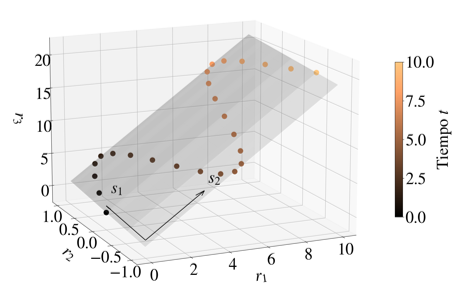

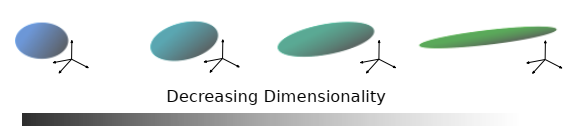

 Esta es una conclusión provisoria, es algo que estuve pensando bastante pero podría estar equivocada, espero que lo podamos hablar en la presentación. No encontré ningún artículo que mida la dimensionalidad efectiva a partir de la matriz de Gram de distancias geodésicas.

A continuación muestro la dimensión de participación calculada a partir de los dos métodos.

 Mi idea no es comparar ambos resultados ya que no representan lo mismo, simplemente visualicemos las tendencias.

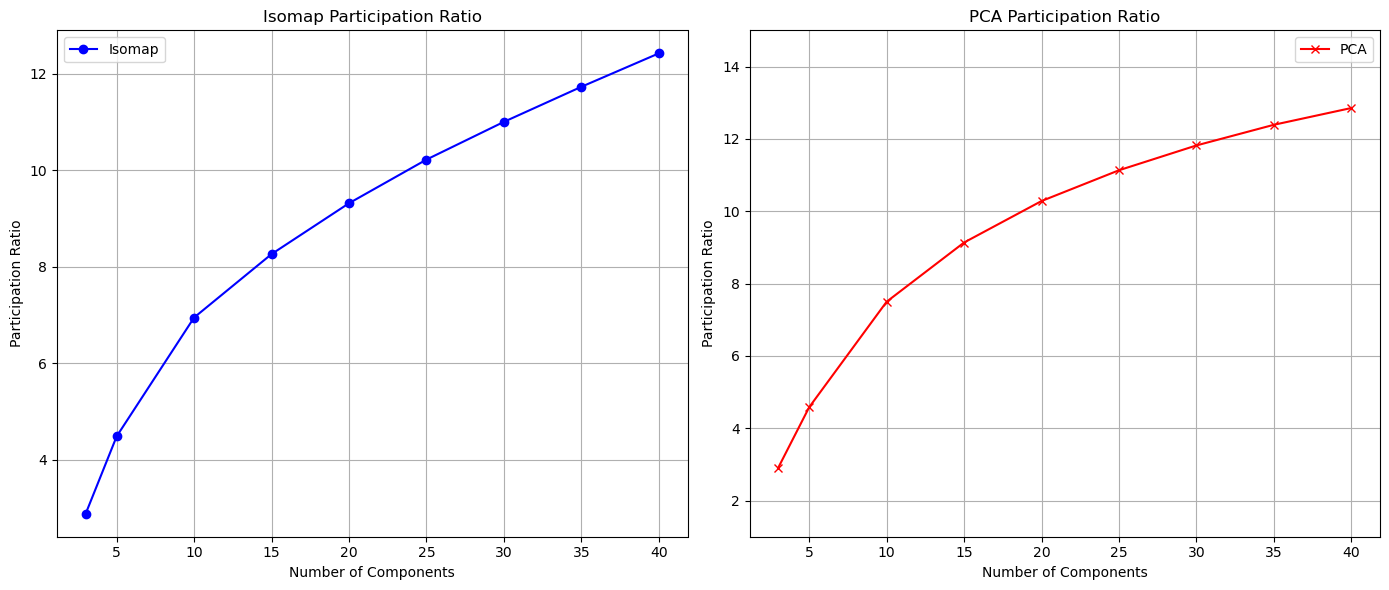

In [52]:
# Función para calcular la dimensión de participación
def participation_ratio(eigenvalues):
    return (np.sum(eigenvalues) ** 2) / np.sum(eigenvalues ** 2)

participation_ratios_isomap = []
participation_ratios_pca = []
# Lista de valores de n_components a evaluar
n_components_list = [3, 5, 10, 15, 20, 25, 30, 35, 40]

for n_components in n_components_list:
    isomap = Isomap(n_neighbors=30, n_components=n_components)
    data_isomap = isomap.fit_transform(df1)
    
    covariance_matrix_isomap = np.cov(data_isomap, rowvar=False)
    eigenvalues_isomap = np.linalg.eigvalsh(covariance_matrix_isomap)
    pr_isomap = participation_ratio(eigenvalues_isomap)
    participation_ratios_isomap.append(pr_isomap)

    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(df1)
    
    eigenvalues_pca = pca.explained_variance_
    pr_pca = participation_ratio(eigenvalues_pca)
    participation_ratios_pca.append(pr_pca)

# Crear subplots horizontales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graficar Isomap
ax1.plot(n_components_list, participation_ratios_isomap, marker='o', color = 'b', label='Isomap')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Participation Ratio')
ax1.set_title('Isomap Participation Ratio')
ax1.legend()
ax1.grid(True)

# Graficar PCA
ax2.plot(n_components_list, participation_ratios_pca, marker='x', color = 'r', label='PCA')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Participation Ratio')
ax2.set_title('PCA Participation Ratio')
ax2.legend()
ax2.grid(True)

# Ajustar y mostrar la figura
plt.tight_layout()
plt.ylim(1,15)
plt.show()

### UMAP y tSNE

(2000, 200)


c:\Users\Martina\miniconda3\envs\TPF\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


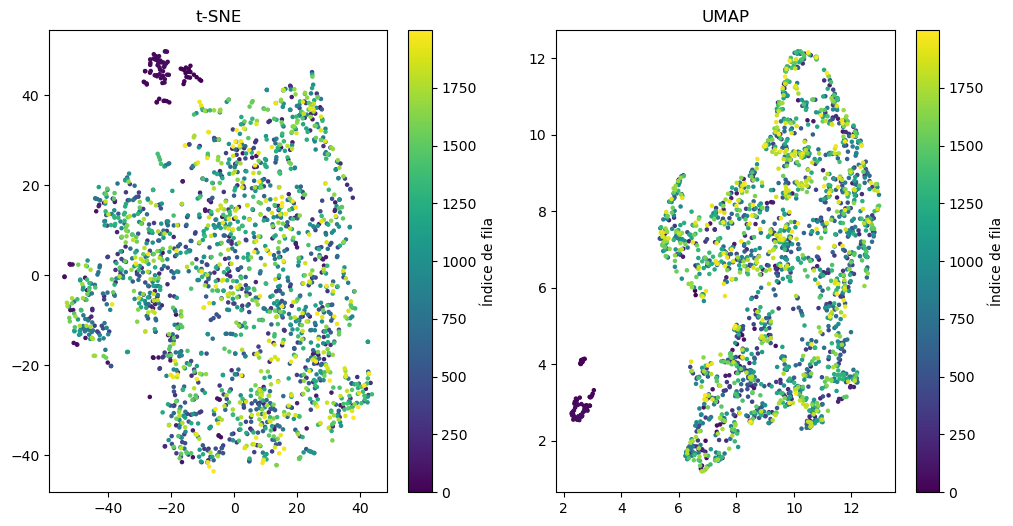

In [67]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

file_path = 'rprom_matrix_pqif=_0.5.csv' 
data = pd.read_csv(file_path)
data_array = data.values
print(data_array.shape)  # Debe ser (2000, 200)

# Normalizar los datos
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_array)

labels = np.arange(data_normalized.shape[0])

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_normalized)

# Aplicar UMAP
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=42)
data_umap = umap_model.fit_transform(data_normalized)

# Visualización de los resultados
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='viridis', s=5)
plt.colorbar(label='Índice de fila')
plt.title('t-SNE')

plt.subplot(1, 2, 2)
plt.scatter(data_umap[:, 0], data_umap[:, 1], c=labels, cmap='viridis', s=5)
plt.colorbar(label='Índice de fila')
plt.title('UMAP')
plt.show()

Autoencoders

Importemos las librerías que usaremos en esa sección

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


Hagamos un reescaleo de los datos.

In [54]:
scaler = StandardScaler()
scaler.fit(data_array)
x_data = scaler.transform(data_array)

Dividamos los datos del archivo en entrenamiento y validación.

In [55]:
# Dividir los datos en train + val (1800 datos) y test (200 datos)
train_val_data, x_test = train_test_split(x_data, test_size=200, random_state=42)

# Dividir los datos de train + val en train (1600 datos) y val (200 datos)
x_train, x_val = train_test_split(train_val_data, test_size=200, random_state=42)

Empecemos con un modelo básico para nuestro autoencoder.

Tomemos como dimensión del espacio latente, la mitad de la dimensión del espacio original.

In [56]:

input_dim = 200

latent_dim = 100

encoder_input = Input(shape=(input_dim,))

x = Dense(128, activation='relu')(encoder_input)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
#Esperamos que las salidas de cada capa extraigan características cada vez más abstractas y útiles del input
#Introducimos una función de activación para introducir no linealidades en el modelo. 
#NO tiene el problema de desvanecimiento del gradiente que tienen otras activaciones
# Introduce esparsidad dado que solo se activan las neuronas con salidas positivas.

encoder_output = Dense(latent_dim)(x)  
encoder = Model(encoder_input, encoder_output)

# Decoder definition
decoder_input = Input(shape=(latent_dim,))

x = Dense(32, activation='relu')(decoder_input)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
decoder_output = Dense(input_dim)(x) 

decoder = Model(decoder_input, decoder_output)

# Autoencoder definition
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder(autoencoder_input))
autoencoder1 = Model(autoencoder_input, autoencoder_output)

# Compile the autoencoder
autoencoder1.compile(loss='mse', optimizer='adam')

# Model summary
autoencoder1.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_13 (Functional)      │ (None, 100)            │        39,364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_15 (Functional)      │ (None, 200)            │        39,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,828 (307.92 KB)

 Trainable params: 78,828 (307.92 KB)

 Non-trainable params: 0 (0.00 B)

Definamos una función para graficar la predicción del autoencoder. Podemos visualizar la predicción de dos maneras distintas:
- Para un instante de tiempo dado: Eje x: ínidice de una neurona / Eje y: salida de dicha neurona 
- Para una neurona particular: Eje x: tiempo / Eje y: salida de la neurona 

In [57]:
def plot_feature_orig_vs_recon(autoencoder, x_data, feature_idx=0, title=''):
    plt.plot(autoencoder.predict(x_data)[:, feature_idx], label='reconstructed', color='orange')
    plt.plot(x_data[:, feature_idx], label='original', color='blue')
    plt.xlabel('Tiempo')
    plt.ylabel('Salida')
    plt.xlim(300,400)
    plt.legend(title=f'Neurona {feature_idx}')
    plt.grid(True)
    plt.show()

def plot_orig_vs_recon(autoencoder, x_data, title=''):
    for i in range(3):
        plt.subplot(3, 1, i+1)
        idx = random.sample(range(x_data.shape[0]), 1)
        plt.plot(autoencoder.predict(x_data[idx]).squeeze(), label=f'reconstructed' if i == 0 else '')
        plt.plot(x_data[idx].squeeze(), label='original' if i == 0 else '')
        plt.ylim(-5, 5)
        plt.xlabel('Neurona')
        plt.ylabel('Salida')
        plt.grid(True)
        if i == 0: plt.legend(title=f'Tiempo {i}')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


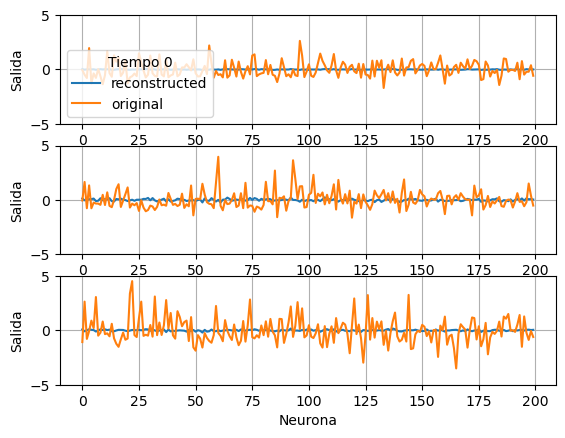

In [58]:
plot_orig_vs_recon(autoencoder1, x_train, 'Before training the encoder-decoder')

In [59]:
# Early Stopping: detiene el entrenamiento cuando el modelo deja de mejorar el conjunto de validación (monitorea val loss).
#Evita sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
model_history = autoencoder1.fit(x_train, x_train, epochs=5000, batch_size=32, verbose=0, 
                                callbacks=[early_stopping], validation_data=(x_val, x_val))



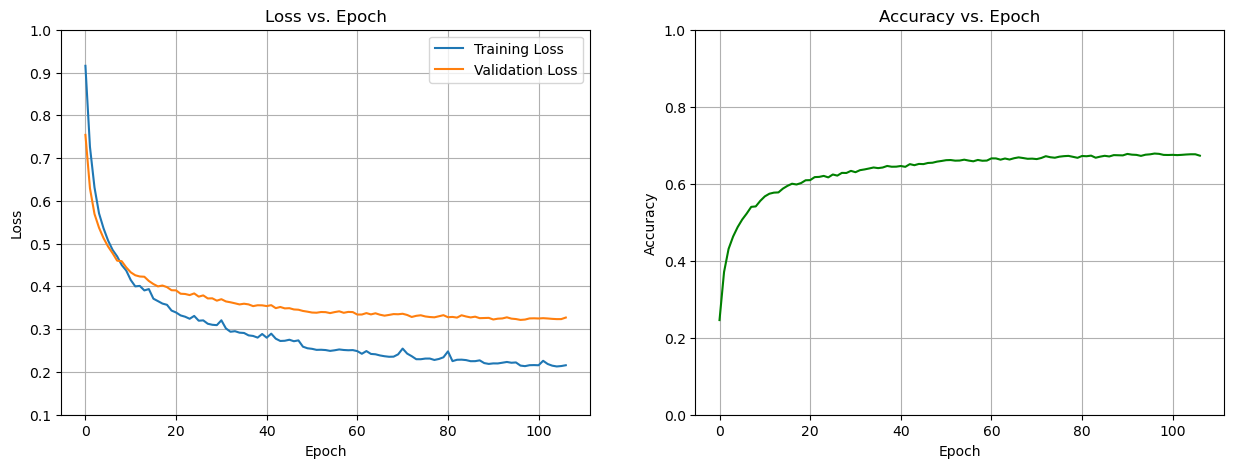

In [60]:
mse = model_history.history['val_loss']
#Defino una métrica de precisión, cuando el MSE es más bajo, la precisión es más alta.
accuracy = [1 - m for m in mse]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1, 1)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy', color='green')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)

plt.show()

Los valores son bastante razonables. Visualicemos los resultados como las gráficas mencionadas previamente.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


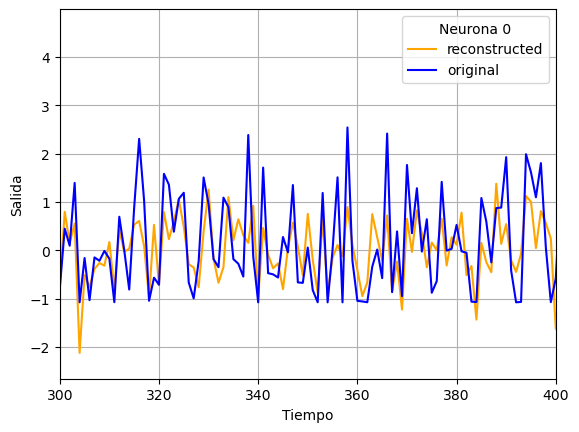

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


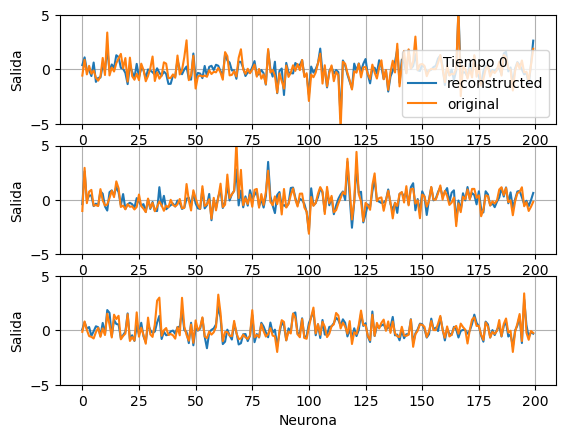

In [61]:
plot_feature_orig_vs_recon(autoencoder1,x_train, feature_idx=0, title='Reconstruction of Feature 0')
plot_orig_vs_recon(autoencoder1, x_train, 'After training the encoder-decoder')

Vemos que el modelo puede predecir acordemente las salidas de las neuronas a distintos instantes de tiempo.

Agreguemos términos de regularización para ver si podemos mejorar la situación de overfitting.

In [62]:
from keras.regularizers import l1, l2
#L1 y L2 penalizan la función de pérdida
#l1 .> penalización dada por la suma de los valores absolutos de los pesos
#l2 .> penalización dada por la suma de los cuadrados de los pesos

# Encoder definition with regularization
encoder_input = Input(shape=(input_dim,))

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(encoder_input)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)

encoder_output = Dense(latent_dim)(x)  
encoder = Model(encoder_input, encoder_output)

# Decoder definition with regularization
decoder_input = Input(shape=(latent_dim,))

x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(decoder_input)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
decoder_output = Dense(input_dim)(x) 

decoder = Model(decoder_input, decoder_output)

# Autoencoder definition
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder(autoencoder_input))
autoencoder3 = Model(autoencoder_input, autoencoder_output)

# Compile the autoencoder
autoencoder3.compile(loss='mse', optimizer='adam')

# Model summary
autoencoder3.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_19 (Functional)      │ (None, 100)            │        39,364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_21 (Functional)      │ (None, 200)            │        39,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,828 (307.92 KB)

 Trainable params: 78,828 (307.92 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
model_history = autoencoder3.fit(x_train, x_train, epochs=5000, batch_size=32, verbose=0, 
                                callbacks=[early_stopping], validation_data=(x_val, x_val))


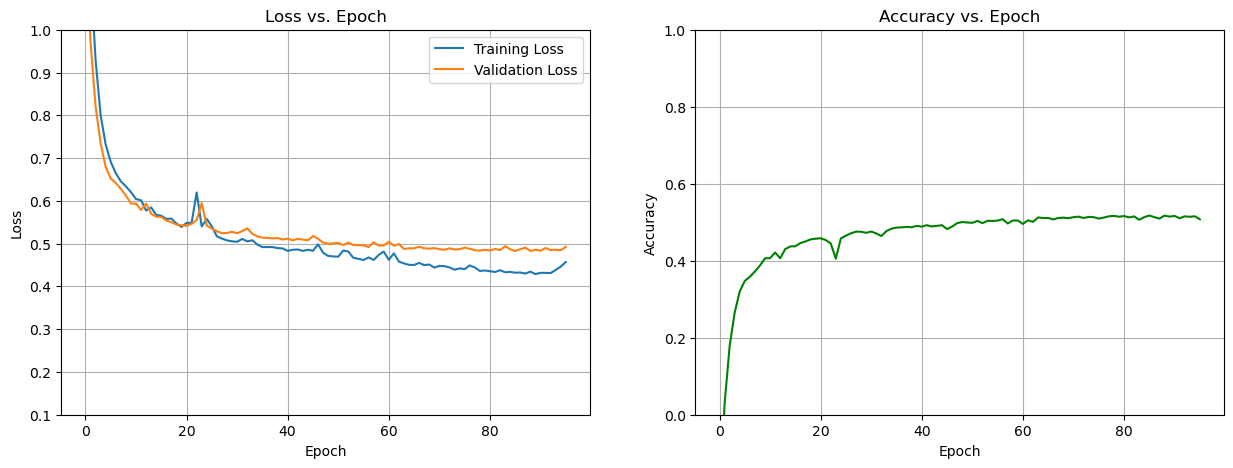

In [64]:
mse = model_history.history['val_loss']
accuracy = [1 - m for m in mse]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1, 1)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy', color='green')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)

plt.show()

Disminuye la diferencia entre el error de validación y de entrenamiento, pero ambos son más elevados.

Evaluemos que sucede con los datos de testeo.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.3017  
Loss en datos de prueba: 0.32389602065086365
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


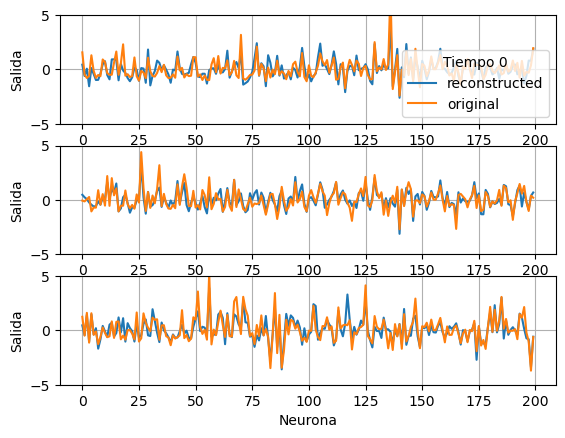

In [65]:
loss_test = autoencoder1.evaluate(x_test, x_test)
print(f'Loss en datos de prueba: {loss_test}')

# Reconstruyo y grafico para todas las neuronas y di>stintos instantes de tiempo
plot_orig_vs_recon(autoencoder1, x_test, title='Reconstrucción de varias neuronas')


**Conclusiones:**

- **Análisis Exploratorio de Datos (EDA):** El EDA reveló una correlación lineal entre los datos en pares y me que proporcionó una mejor comprensión del comportamiento del sistema.

- **Reducción de Dimensionalidad:** Se aplicaron los métodos de reducción de dimensionalidad PCA e Isomap. Se encontró que el modelo Isomap tiene una varianza residual menor que PCA, lo que sugiere que es mejor preservando distancias.

- **Dimensión de Participación (Dpr):** Se intentó encontrar una medida descriptiva análoga al Dpr utilizando la matriz de Gram del modelo Isomap. Esta relación describiría la dimensionalidad efectiva de los datos en la manifold.

- **Modelo de Autoencoder:** Se utilizó un modelo de autoencoder que pudo reproducir los datos de manera razonable. Sin embargo, existen áreas de mejora para evitar que el modelo aprenda la identidad y mejorar su capacidad de generalización.

**Mejoras Propuestas:**

1. **Exploración de Tamaños de Conexiones entre Neuronas:** Se propone investigar cómo varía el Dpr de la matriz de Gram al cambiar el tamaño de las conexiones entre neuronas, ya que existen modelos para la dimensión de participacion (PCA) con dicho tamaño.

2. **Mejora del Modelo de Autoencoder:** Se podría mejorar el modelo de autoencoder agregando sparseness o utilizando un denoiser autoencoder para evitar que aprenda la identidad y mejorar su capacidad de generalización.

3. **Exploración de Dimensionalidades Latentes:** Quisiera explorar cómo varía el desempeño del modelo con diferentes dimensionalidades para las variables latentes..

4. **Agregar Capas y Neuronas:** Se podría con la agregar  capas y neuronas al modelo de autoencoder para mejorar su capacidad para capturar la complejidad de los datos.
